In [10]:
import pandas as pd
import geopandas
import geoplot

In [2]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [3]:
col_description = pd.read_csv(path + 'crime_documentation.txt')

In [12]:
nypd = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)
nypd

,patrol_bor,pct,phase,sct_text,sctr_float,sector,sq_feet,sq_mile_ne,sq_miles,date_start,time_start,geometry
0,PBQS,102,14,102A,0.0,102A,3.927381e+07,1.408754,1.408760,2018-07-09,00:00:00.000,"POLYGON ((-73.84120 40.68335, -73.84125 40.683..."
1,PBQS,102,14,102B,1.0,102B,2.939626e+07,1.054446,1.054450,2018-07-09,00:00:00.000,"POLYGON ((-73.84451 40.68242, -73.84494 40.682..."
2,PBQS,102,14,102C,2.0,102C,2.375686e+07,0.852160,0.852163,2018-07-09,00:00:00.000,"POLYGON ((-73.82611 40.71557, -73.82605 40.715..."
3,PBQS,102,14,102D,3.0,102D,4.088754e+07,1.466639,1.466645,2018-07-09,00:00:00.000,"POLYGON ((-73.83681 40.70844, -73.83694 40.708..."
4,PBQN,104,15,104A,4.0,104A,4.451591e+07,2.194020,1.596795,2018-10-01,00:00:00.000,"POLYGON ((-73.85845 40.70578, -73.85828 40.705..."
...,...,...,...,...,...,...,...,...,...,...,...,...
297,PBBS,061,12,061C,340.0,61C,2.529982e+07,0.907506,0.907510,2018-01-22,00:00:00.000,"POLYGON ((-73.93609 40.60387, -73.93426 40.602..."
298,PBBS,061,12,061D,341.0,61D,4.940196e+07,1.772051,1.772059,2018-01-22,00:00:00.000,"POLYGON ((-73.93183 40.59299, -73.93176 40.592..."
299,PBSI,120,03,120A,336.0,120A,5.166329e+07,1.853165,1.853173,2015-12-14,00:00:00.000,"POLYGON ((-74.08777 40.63172, -74.08773 40.631..."
300,PBSI,120,03,120B,337.0,120B,3.139478e+07,1.126133,1.126137,2015-12-14,00:00:00.000,"POLYGON ((-74.07337 40.63661, -74.07347 40.636..."


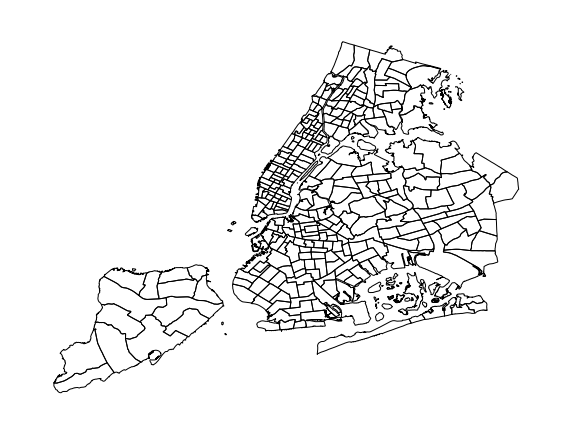

In [11]:
geoplot.polyplot(nypd, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)